# **New York City Yellow Taxi Data**

## Objective
In this case study we perform exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City.

## **Problem Statement**
Use the 2023 NYC taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Steps-by-step approach

1. Data Loading
2. Data Cleaning
3. Exploratory Analysis
4. Creating Visualisations to Support the Analysis
5. Deriving Insights

---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, we will only be using the data from 2023.

The data for each month is present in a different parquet file. There are twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

Link to the TLC trip records page: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
Data description file: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

### Import Libraries

In [215]:
# Import warnings
import warnings

# Libraries needed for analysis
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

### **1.1** Load the dataset

These individual .parquet files can be downloaded from the link given in README.md file to execute below cell

In [216]:
# # Loading one file
# df = pd.read_parquet('../dataset/trip_records/2023-1.parquet')
# print("Shape : ", df.shape)
# df.head()

Just a single parquet file has 30,41,714 rows and 19 columns. 12 such files would mean 3,65,00,568 rows. This is computationally very expensive. Hence we sample it such that it is a representative of the overall data.

#### Sampling the Data
> We iterate through each file and extract the date and hour values. For each day, each hour we sample a percentage of data (1.5%) to create a smaller dataset (~6,00,000 rows).<br>
> It is recommmended to not load all the files at once to avoid memory overload. <br>
> The code below illustrates the sampling process. Since iterating through every file is time-consuming, the final sampled CSV has already been generated and is included in the dataset for direct use.


---

In [217]:
# # Take a small percentage of entries from each hour of every date.
# # Create a single dataframe for the year combining all the monthly data

# # Select the folder having data files
# os.chdir('../dataset/trip_records')

# # Create a list of all the twelve files to read
# file_list = os.listdir()

# # initialise an empty dataframe
# df = pd.DataFrame()

# # iterate through the list of files and sample one by one:
# for file_name in file_list:
#     try:
#         # file path for the current file
#         file_path = os.path.join(os.getcwd(), file_name)

#         # Reading the current file
#         df_temp = pd.read_parquet(file_path)


#         # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
#         # After completing iteration through each date, we will append this data to the final dataframe.
#         sampled_data = pd.DataFrame()

#         # Loop through dates and then loop through every hour of each date
#         df_temp['tpep_pickup_datetime'] = pd.to_datetime(df_temp['tpep_pickup_datetime'])
#         for date in df_temp['tpep_pickup_datetime'].dt.date.unique():
#             # Iterate through each hour of the selected date
#             for hour in df_temp['tpep_pickup_datetime'].dt.hour.unique():
#                 # Sample 5% of the hourly data randomly
#                 sample = df_temp[(df_temp['tpep_pickup_datetime'].dt.date == date) &  (df_temp['tpep_pickup_datetime'].dt.hour == hour)].sample(frac = 0.015, random_state = 42)
#                 # add data of this hour to the dataframe
#                 sampled_data = pd.concat([sampled_data, sample], axis=0)

#         # Concatenate the sampled data of all the dates to a single dataframe
#         df = pd.concat([df,sampled_data], axis=0)# we initialised this empty DF earlier

#     except Exception as e:
#         print(f"Error reading file {file_name}: {e}")

# # Store the df in csv/parquet
# df.to_parquet('2023_yellow_taxi_trip_data.parquet')

## **2** Data Cleaning


In [218]:
# Load the new data file
# os.chdir('../dataset/trip_records')
print(os.getcwd())
df = pd.read_parquet('../dataset/trip_records/2023_yellow_taxi_trip_data.parquet')

c:\Users\amdhr\upgrad\eda\nyc_taxi\github\EDA-NYC-taxi\notebook


In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 597165 entries, 2706519 to 2969486
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               597165 non-null  int64         
 1   tpep_pickup_datetime   597165 non-null  datetime64[us]
 2   tpep_dropoff_datetime  597165 non-null  datetime64[us]
 3   passenger_count        576965 non-null  float64       
 4   trip_distance          597165 non-null  float64       
 5   RatecodeID             576965 non-null  float64       
 6   store_and_fwd_flag     576965 non-null  object        
 7   PULocationID           597165 non-null  int64         
 8   DOLocationID           597165 non-null  int64         
 9   payment_type           597165 non-null  int64         
 10  fare_amount            597165 non-null  float64       
 11  extra                  597165 non-null  float64       
 12  mta_tax                597165 non-null  fl

#### **2.1** Fixing Columns

**2.1.1**
Fix the index and drop unnecessary columns

In [220]:
# Fix the index and drop any columns that are not needed
# To check: Which columns can be dropped
df = df.reset_index(drop=True)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,airport_fee
0,2,2023-09-01 00:39:59,2023-09-01 01:00:28,NaN,4.71,NaN,None,113,238,0,24.83,0.0,0.5,4.32,0.00,1.0,33.15,NaN,NaN,NaN
1,2,2023-09-01 00:24:50,2023-09-01 00:27:19,2.0,0.56,1.0,N,142,142,2,5.10,1.0,0.5,0.00,0.00,1.0,10.10,2.5,0.00,NaN
2,2,2023-09-01 00:19:27,2023-09-01 01:04:02,2.0,18.46,2.0,N,132,163,1,70.00,0.0,0.5,15.71,6.94,1.0,98.40,2.5,1.75,NaN
3,2,2023-09-01 00:42:13,2023-09-01 01:20:20,2.0,13.71,1.0,N,249,180,4,59.70,1.0,0.5,0.00,0.00,1.0,64.70,2.5,0.00,NaN
4,2,2023-09-01 00:11:38,2023-09-01 00:17:56,1.0,0.71,1.0,N,144,232,1,7.90,1.0,0.5,2.00,0.00,1.0,14.90,2.5,0.00,NaN


**2.1.2**
There are two airport fee columns. This is possibly an error in naming columns. We can combine the two.

In [221]:
# Combine the two airport fee columns
# Choose non-zero fee value
print("airport_fee column values: ", df['airport_fee'].unique())
print("Airport_fee column values: ", df['Airport_fee'].unique())
df[['Airport_fee', 'airport_fee']] = df[['Airport_fee', 'airport_fee']].fillna(0)
df['airportFee'] = np.where(df['Airport_fee'] != 0, df['Airport_fee'], df['airport_fee'])
df.drop(['Airport_fee', 'airport_fee'], axis=1, inplace=True)
df.head()

airport_fee column values:  [ nan 1.25 0.  ]
Airport_fee column values:  [  nan  0.    1.75  1.25 -1.75]


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airportFee
0,2,2023-09-01 00:39:59,2023-09-01 01:00:28,NaN,4.71,NaN,None,113,238,0,24.83,0.0,0.5,4.32,0.00,1.0,33.15,NaN,0.00
1,2,2023-09-01 00:24:50,2023-09-01 00:27:19,2.0,0.56,1.0,N,142,142,2,5.10,1.0,0.5,0.00,0.00,1.0,10.10,2.5,0.00
2,2,2023-09-01 00:19:27,2023-09-01 01:04:02,2.0,18.46,2.0,N,132,163,1,70.00,0.0,0.5,15.71,6.94,1.0,98.40,2.5,1.75
3,2,2023-09-01 00:42:13,2023-09-01 01:20:20,2.0,13.71,1.0,N,249,180,4,59.70,1.0,0.5,0.00,0.00,1.0,64.70,2.5,0.00
4,2,2023-09-01 00:11:38,2023-09-01 00:17:56,1.0,0.71,1.0,N,144,232,1,7.90,1.0,0.5,2.00,0.00,1.0,14.90,2.5,0.00


**2.1.3**
Fix columns with negative (monetary) values

In [222]:
df_temp = df[df['total_amount'] < 0]

# Analyse RatecodeID for the negative fare amounts
df_temp['RatecodeID'].value_counts()

RatecodeID
1.0    16
2.0    10
5.0     1
Name: count, dtype: int64

In [223]:
# Find which columns have negative values

# Get numeric columns
numeric_cols = df_temp.select_dtypes(include='number').columns

# Check which of these columns have any negative values
negative_value_cols = [col for col in numeric_cols if (df_temp[col] < 0).any()]
negative_value_cols

['mta_tax',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airportFee']

In [224]:
# fix these negative values: These rows can be removed as there are very few rows
df = df[df['total_amount'] > 0]
df.shape

(597054, 19)

### **2.2** Handling Missing Values

**2.2.1**
Find the proportion of missing values in each column




In [225]:
# Find the proportion of missing values in each column
missing = df.isnull().sum() / len(df)
print(missing)

VendorID                 0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          0.033828
trip_distance            0.000000
RatecodeID               0.033828
store_and_fwd_flag       0.033828
PULocationID             0.000000
DOLocationID             0.000000
payment_type             0.000000
fare_amount              0.000000
extra                    0.000000
mta_tax                  0.000000
tip_amount               0.000000
tolls_amount             0.000000
improvement_surcharge    0.000000
total_amount             0.000000
congestion_surcharge     0.033828
airportFee               0.000000
dtype: float64


**2.2.2**
Handling missing values in `passenger_count`

In [226]:
# Display the rows with null values
# Impute NaN values in 'passenger_count' with the mode
print(missing[missing > 0])
df['passenger_count'] = df['passenger_count'].fillna(df['passenger_count'].mode()[0])

passenger_count         0.033828
RatecodeID              0.033828
store_and_fwd_flag      0.033828
congestion_surcharge    0.033828
dtype: float64


Handle zeroes in passenger_count

In [227]:
# Replce zeros with mode
df['passenger_count'] = df['passenger_count'].replace(0, df['passenger_count'].mode()[0])

**2.2.3**
Handle missing values in `RatecodeID`

In [228]:
# Fix missing values in 'RatecodeID': Although there is no NA, 99 is invalid
# Replace it with mode values
df['RatecodeID'] = df['RatecodeID'].replace(
    99, df['RatecodeID'].mode()[0]
)
df['RatecodeID'].value_counts()

RatecodeID
1.0    547991
2.0     22541
5.0      3260
3.0      1891
4.0      1174
Name: count, dtype: int64

**2.2.4**
Impute NaN in `congestion_surcharge`

In [229]:
# handle null values in congestion_surcharge: Most likely there is no surcharge when NA
df['congestion_surcharge'] = df['congestion_surcharge'].fillna(0)
df['congestion_surcharge'].isnull().sum()

0

In [230]:
# Handle any remaining missing values
df['store_and_fwd_flag'].value_counts(dropna=False)
df['store_and_fwd_flag'].isna().mean()
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].fillna(df['store_and_fwd_flag'].mode()[0])

### **2.3** Handling Outliers

Before we start fixing outliers, let's perform outlier analysis.

In [231]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns
df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airportFee
count,597054.000000,597054,597054,597054.000000,597054.000000,576857.000000,597054.000000,597054.000000,597054.000000,597054.000000,597054.000000,597054.000000,597054.000000,597054.000000,597054.000000,597054.000000,597054.000000,597054.000000
mean,1.733781,2023-07-02 20:00:46.960248,2023-07-02 20:18:09.015175,1.369712,3.665310,1.074343,165.239318,164.018586,1.163650,20.056543,1.584680,0.495426,3.542225,0.591406,0.999212,29.107436,2.230351,0.137640
min,1.000000,2023-01-01 00:02:19,2023-01-01 00:09:40,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-2.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.000000,2023-04-02 16:13:35.500000,2023-04-02 16:34:57,1.000000,1.050000,1.000000,132.000000,113.000000,1.000000,9.300000,0.000000,0.500000,1.000000,0.000000,1.000000,15.960000,2.500000,0.000000
50%,2.000000,2023-06-27 15:20:42,2023-06-27 15:43:13.500000,1.000000,1.790000,1.000000,162.000000,162.000000,1.000000,13.500000,1.000000,0.500000,2.850000,0.000000,1.000000,21.000000,2.500000,0.000000
75%,2.000000,2023-10-06 19:49:12.750000,2023-10-06 20:06:56.750000,1.000000,3.400000,1.000000,234.000000,234.000000,1.000000,21.900000,2.500000,0.500000,4.420000,0.000000,1.000000,30.800000,2.500000,0.000000
max,6.000000,2023-12-31 23:54:03,2024-01-01 20:14:57,9.000000,26217.980000,5.000000,265.000000,265.000000,4.000000,143163.450000,14.250000,4.000000,150.290000,143.000000,1.000000,143167.450000,2.500000,1.750000
std,0.447217,NaN,NaN,0.861654,65.202066,0.394207,64.032014,69.806442,0.506531,186.140080,1.824779,0.047994,4.023265,2.176774,0.025552,186.632052,0.775508,0.456972


**2.3.1**
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

In [232]:
# remove passenger_count > 6
df = df[df['passenger_count'] <= 6]


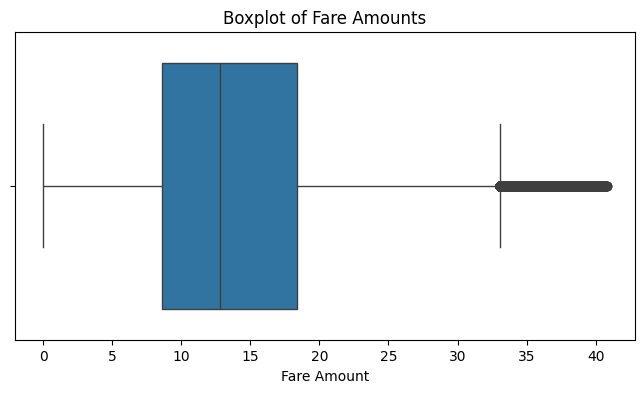

In [233]:
# Fare amount

# Calculate Q1, Q3, IQR
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['fare_amount'] < upper_bound) & (df['fare_amount'] > lower_bound)]

# Create boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['fare_amount'])
plt.title('Boxplot of Fare Amounts')
plt.xlabel('Fare Amount')
plt.show()

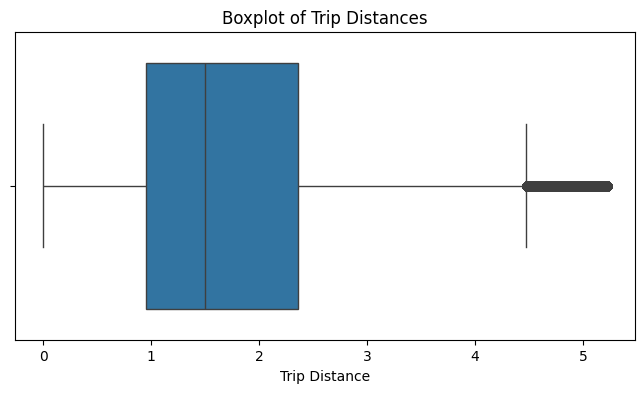

In [234]:
# Trip distance

# Calculate Q1, Q3, IQR
Q1 = df['trip_distance'].quantile(0.25)
Q3 = df['trip_distance'].quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['trip_distance'] < upper_bound) & (df['trip_distance'] > lower_bound)]

# Create boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['trip_distance'])
plt.title('Boxplot of Trip Distances')
plt.xlabel('Trip Distance')
plt.show()

In [235]:
# Continue with outlier handling
df['trip_duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']

# Trip distance is very less but fare amount is very high
df = df[~((df['fare_amount'] > 300) & (df['trip_distance'] == 0))]

#Remove payment type 0 as this is not valid
df = df[df['payment_type'] != 0]

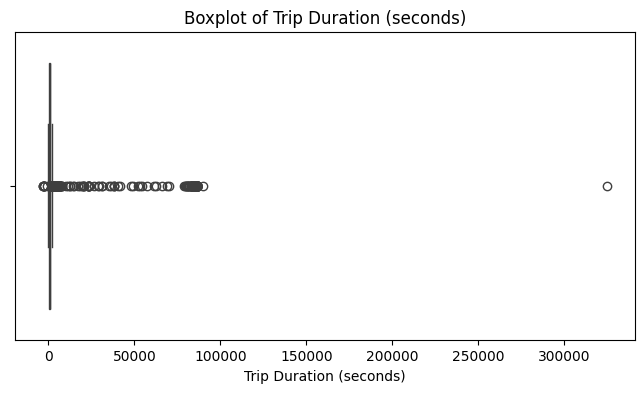

In [236]:
# Create boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['trip_duration'].dt.total_seconds())
plt.title('Boxplot of Trip Duration (seconds)')
plt.xlabel('Trip Duration (seconds)')
plt.show()

# Remove outlier
df = df[df['trip_duration'].dt.total_seconds() < 3*60*60]

## **3** Exploratory Data Analysis

In [237]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airportFee',
 'trip_duration']

#### **3.1** General EDA: Finding Patterns and Trends

**3.1.1**
Categorise the varaibles into Numerical or Categorical.

***Categorical:***

1. `VendorID`
2. `tpep_dropoff_datetime`
3. `tpep_pickup_datetime`
4. `RatecodeID`
5. `PULocationID`
6. `DOLocationID`
7. `payment_type`

***Numerical:***

1. `passenger_count`
2. `trip_duration`
3. `trip_distance`
4. `pickup_hour`
5. `tpep_dropoff_datetime`
6. `tpep_pickup_datetime`


**The monetary parameters are all numerical.**
1. `fare_amount`
2. `extra`
3. `mta_tax`
4. `tip_amount`
5. `tolls_amount`
6. `improvement_surcharge`
7. `total_amount`
8. `congestion_surcharge`
9. `airport_fee`


##### Temporal Analysis

**3.1.2**
Analyse the distribution of taxi pickups by hours, days of the week, and months.

pickup_hour
18    35346
17    33092
19    31045
16    29784
15    29644
14    28818
20    27274
13    27227
21    27023
12    26782
11    24780
22    24161
10    22783
9     20789
23    18257
8     18247
7     12794
0     12699
1      8866
2      5883
6      5620
3      3751
4      2071
5      1858
Name: tpep_pickup_datetime, dtype: int64


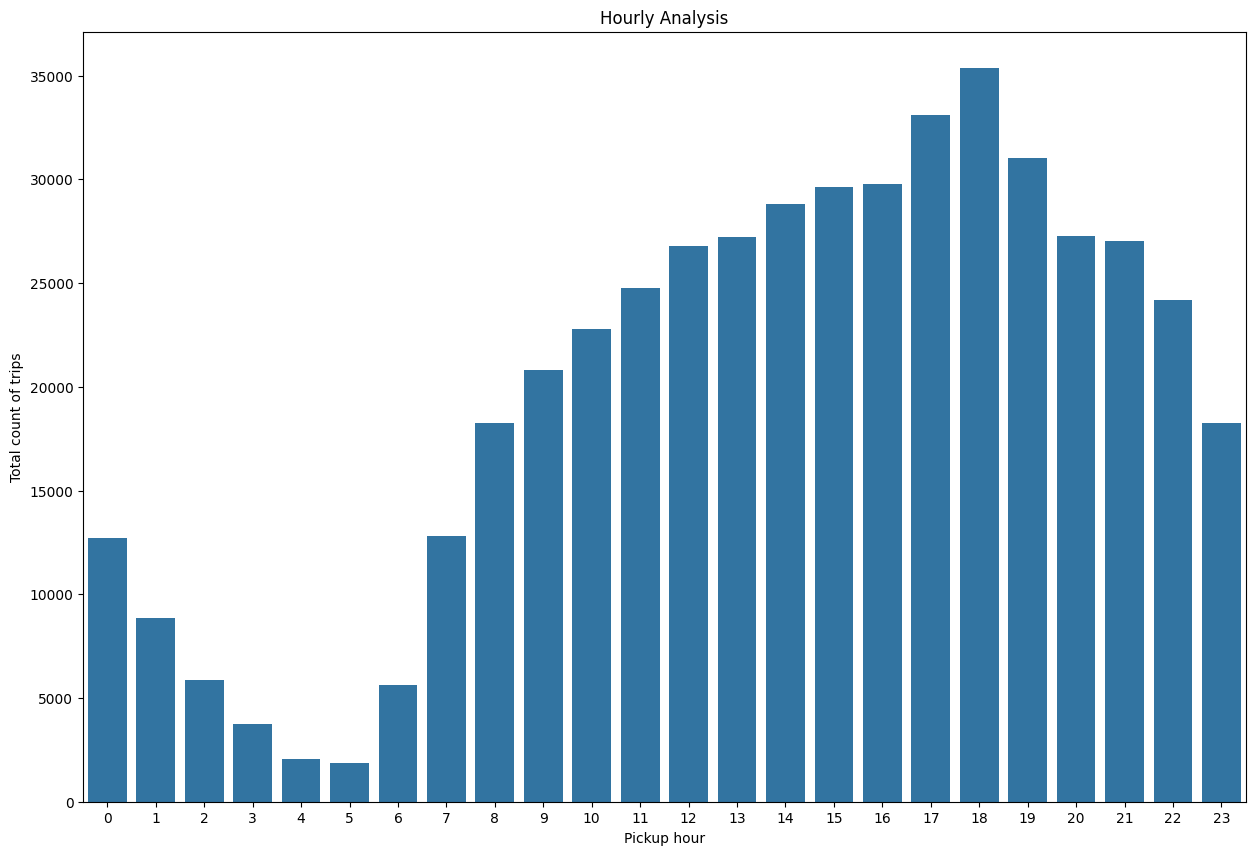

In [238]:
# Extract Pickup hour data
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour

# Group by pickup hour and get trip count
grouped = df.groupby('pickup_hour')['tpep_pickup_datetime'].count().sort_values(ascending=False)
print(grouped)

# Bar plot
plt.figure(figsize=(15,10))
sns.barplot(x='pickup_hour', y='tpep_pickup_datetime', data=grouped.reset_index())
plt.title('Hourly Analysis')
plt.xlabel('Pickup hour')
plt.ylabel('Total count of trips')
plt.show()

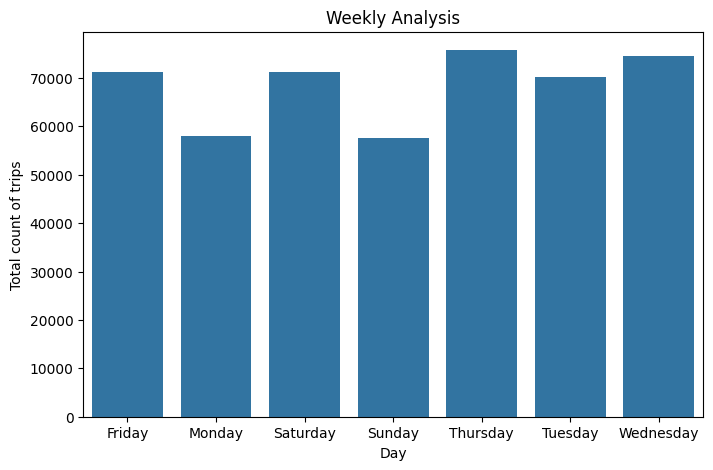

In [239]:
# Find and show the daily trends in taxi pickups (days of the week)
# Extract day data
df['day'] = df['tpep_pickup_datetime'].dt.day_name()

# Group by day and get trip count
grouped = df.groupby('day')['tpep_pickup_datetime'].count().reset_index()

# Bar plot
plt.figure(figsize=(8,5))
sns.barplot(x='day', y='tpep_pickup_datetime', data=grouped)
plt.title('Weekly Analysis')
plt.xlabel('Day')
plt.ylabel('Total count of trips')
plt.show()

month
5     43815
10    43387
3     43133
11    41721
12    41619
6     41387
4     41343
1     39129
2     37394
7     36107
8     34865
9     34694
Name: tpep_pickup_datetime, dtype: int64


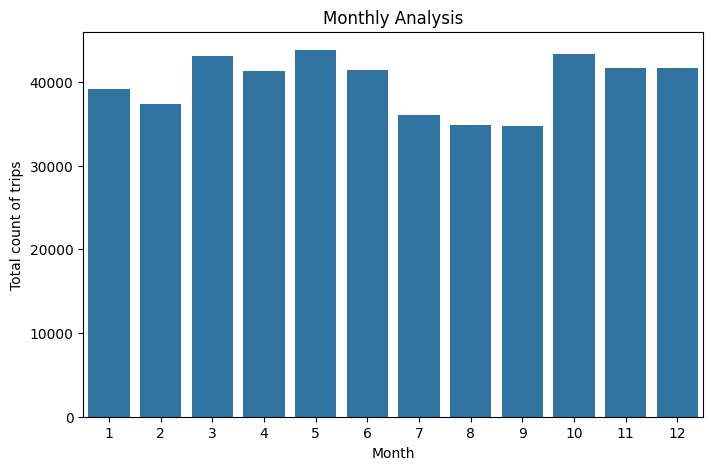

In [240]:
# Show the monthly trends in pickups
# Extract Month data
df['month'] = df['tpep_pickup_datetime'].dt.month

# Group by month and get trip count
grouped = df.groupby('month')['tpep_pickup_datetime'].count().sort_values(ascending=False)
print(grouped)

# Bar plot
plt.figure(figsize=(8,5))
sns.barplot(x='month', y='tpep_pickup_datetime', data=grouped.reset_index())
plt.title('Monthly Analysis')
plt.xlabel('Month')
plt.ylabel('Total count of trips')
plt.show()

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [241]:
# Analyse the above parameters
df[df['total_amount'] < 0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airportFee,trip_duration,pickup_hour,day,month


**3.1.3**
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone.

In [242]:
# Create a df with non zero entries for the selected parameters.
df = df[df['trip_distance'] > 0]
df = df[df['fare_amount'] > 0]
df = df[df['tip_amount'] > 0]
df = df[df['total_amount'] > 0]

**3.1.4**
Analyse the monthly revenue (`total_amount`) trend

month
8     556708.84
7     576062.61
9     596046.73
2     613213.23
1     627761.29
4     675560.47
6     690296.27
3     707736.00
12    714767.42
11    725929.81
5     741919.14
10    755417.13
Name: total_amount, dtype: float64


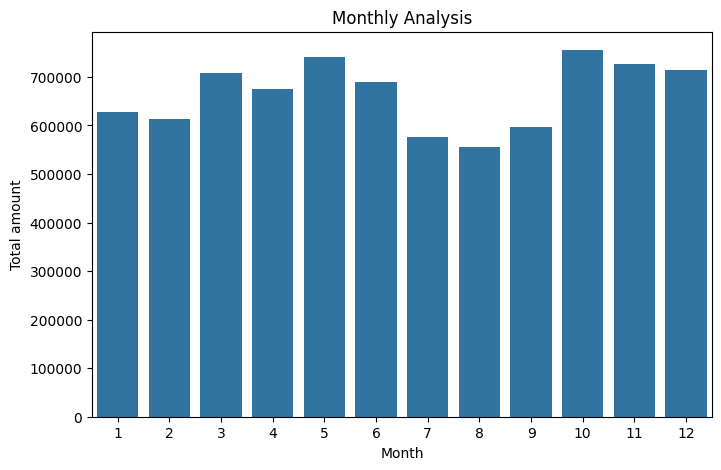

In [243]:
# Group data by month and analyse monthly revenue
grouped = df.groupby('month')['total_amount'].sum().sort_values()

print(grouped)

# Bar plot
plt.figure(figsize=(8,5))
sns.barplot(x='month', y='total_amount', data=grouped.reset_index())
plt.title('Monthly Analysis')
plt.xlabel('Month')
plt.ylabel('Total amount')
plt.show()

**3.1.5**
Show the proportion of each quarter of the year in the revenue

Proportions:  quarter
4    0.275153
2    0.264085
1    0.244156
3    0.216605
Name: total_amount, dtype: float64


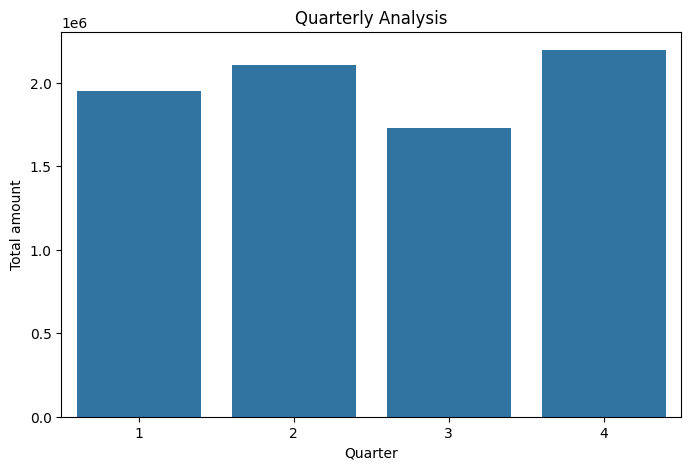

In [244]:
# Calculate proportion of each quarter
df['quarter'] = df['tpep_pickup_datetime'].dt.quarter

# Group data by month and analyse monthly revenue
grouped = df.groupby('quarter')['total_amount'].sum()

grouped_proportion = df.groupby('quarter')['total_amount'].sum()/df['total_amount'].sum()
print("Proportions: ", grouped_proportion.sort_values(ascending=False))

# Bar plot
plt.figure(figsize=(8,5))
sns.barplot(x='quarter', y='total_amount', data=grouped.reset_index())
plt.title('Quarterly Analysis')
plt.xlabel('Quarter')
plt.ylabel('Total amount')
plt.show()

**3.1.6**
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

You can leave out the trips with trip_distance = 0

Correlation value between Fare amount and Trip distance is: 0.8612089576585242


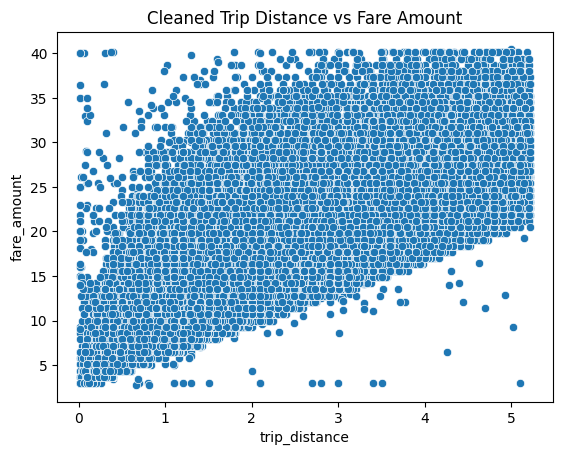

In [245]:
# Show how trip fare is affected by distance
print("Correlation value between Fare amount and Trip distance is:",df['fare_amount'].corr(df['trip_distance']))

#Quick check for any outliers
sns.scatterplot(x='trip_distance', y='fare_amount', data=df)
plt.title("Cleaned Trip Distance vs Fare Amount")
plt.show()

**3.1.7**
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

In [246]:
# Show relationship between fare and trip duration
print("Correlation between Trip duration and Fare amount is: ",df['trip_duration'].corr(df['fare_amount']))

Correlation between Trip duration and Fare amount is:  0.9527897348634614


In [247]:
# Show relationship between fare and number of passengers
print("Correlation between Fare amount and Passenger count is: ",df['fare_amount'].corr(df['passenger_count']))

Correlation between Fare amount and Passenger count is:  0.016396919218649397


In [248]:
# Show relationship between tip and trip distance
print("Correlation between Trip distance and Tip amount is: ",df['trip_distance'].corr(df['tip_amount']))


Correlation between Trip distance and Tip amount is:  0.502240324260024


**3.1.8**
Analyse the distribution of different payment types (`payment_type`)

payment_type
1    373546
2         6
4         4
3         1
Name: payment_type, dtype: int64


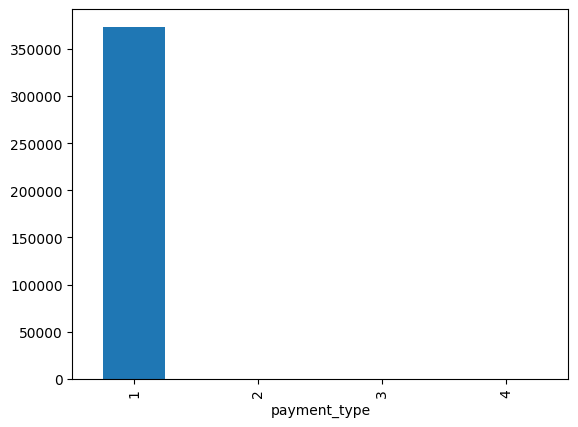

In [249]:
# Analyse the distribution of different payment types (payment_type).
df.groupby('payment_type')['payment_type'].count().plot(kind='bar')

print(df.groupby('payment_type')['payment_type'].count().sort_values(ascending=False))

##### Geographical Analysis

For this, we use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc).
We read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)

 Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

**3.1.9**
Load the shapefile and display it.

In [250]:
# Read the shapefile using geopandas
zones = gpd.read_file('../dataset/taxi_zones/taxi_zones.shp') # read the .shp file using gpd
zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


DataFrame created has columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


<Axes: >

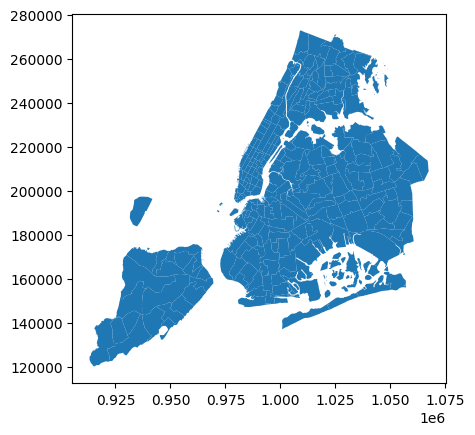

In [251]:
print(zones.info())
zones.plot()

**3.1.10**
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [252]:
# Merge zones and trip records using locationID and PULocationID
merged = df.merge(zones, left_on='PULocationID', right_on='LocationID')
merged.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,day,month,quarter,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,2,2023-09-01 00:11:38,2023-09-01 00:17:56,1.0,0.71,1.0,N,144,232,1,...,Friday,9,3,144,0.027620,0.000047,Little Italy/NoLiTa,144,Manhattan,"POLYGON ((985411.76 200369.518, 985342.573 200..."
1,2,2023-09-01 00:41:08,2023-09-01 00:54:33,5.0,4.39,1.0,N,79,263,1,...,Friday,9,3,79,0.042625,0.000108,East Village,79,Manhattan,"POLYGON ((988746.067 202151.955, 988733.885 20..."
2,2,2023-09-01 00:07:47,2023-09-01 00:18:46,1.0,1.76,1.0,N,48,143,1,...,Friday,9,3,48,0.043747,0.000094,Clinton East,48,Manhattan,"POLYGON ((986694.313 214463.846, 986568.184 21..."
3,1,2023-09-01 00:50:26,2023-09-01 00:59:31,1.0,2.30,1.0,N,114,230,1,...,Friday,9,3,114,0.031727,0.000047,Greenwich Village South,114,Manhattan,"POLYGON ((986306.712 203122.786, 986300.242 20..."
4,1,2023-09-01 00:02:45,2023-09-01 00:12:23,1.0,1.60,1.0,N,211,13,1,...,Friday,9,3,211,0.025235,0.000040,SoHo,211,Manhattan,"POLYGON ((983827.65 201526.658, 983727.737 201..."


**3.1.11**
Group data by location IDs to find the total number of trips per location ID

In [253]:
# Group data by location and calculate the number of trips
merged.groupby('LocationID')['LocationID'].count().sort_values(ascending=False)


LocationID
237    21143
161    19267
236    19219
162    15221
142    14309
       ...  
196        1
219        1
218        1
197        1
1          1
Name: LocationID, Length: 148, dtype: int64

**3.1.12**
We can use the grouped data to add number of trips to the GeoDataFrame and plot a map of zones showing total trips per zone.

In [254]:
# Merge trip counts back to the zones GeoDataFrame
zones['trip_count'] = merged.groupby('LocationID')['LocationID'].count()
zones.head(10)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,trip_count
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",NaN
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",1.0
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2...",NaN
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",NaN
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144...",386.0
5,6,0.150491,0.000606,Arrochar/Fort Wadsworth,6,Staten Island,"POLYGON ((966568.747 158679.855, 966615.256 15...",NaN
6,7,0.107417,0.000390,Astoria,7,Queens,"POLYGON ((1010804.218 218919.641, 1011049.165 ...",NaN
7,8,0.027591,0.000027,Astoria Park,8,Queens,"POLYGON ((1005482.276 221686.466, 1005304.898 ...",68.0
8,9,0.099784,0.000338,Auburndale,9,Queens,"POLYGON ((1043803.993 216615.925, 1043849.708 ...",NaN
9,10,0.099839,0.000436,Baisley Park,10,Queens,"POLYGON ((1044355.072 190734.321, 1044612.122 ...",1.0


**3.1.13**
Plot a color-coded map showing zone-wise trips

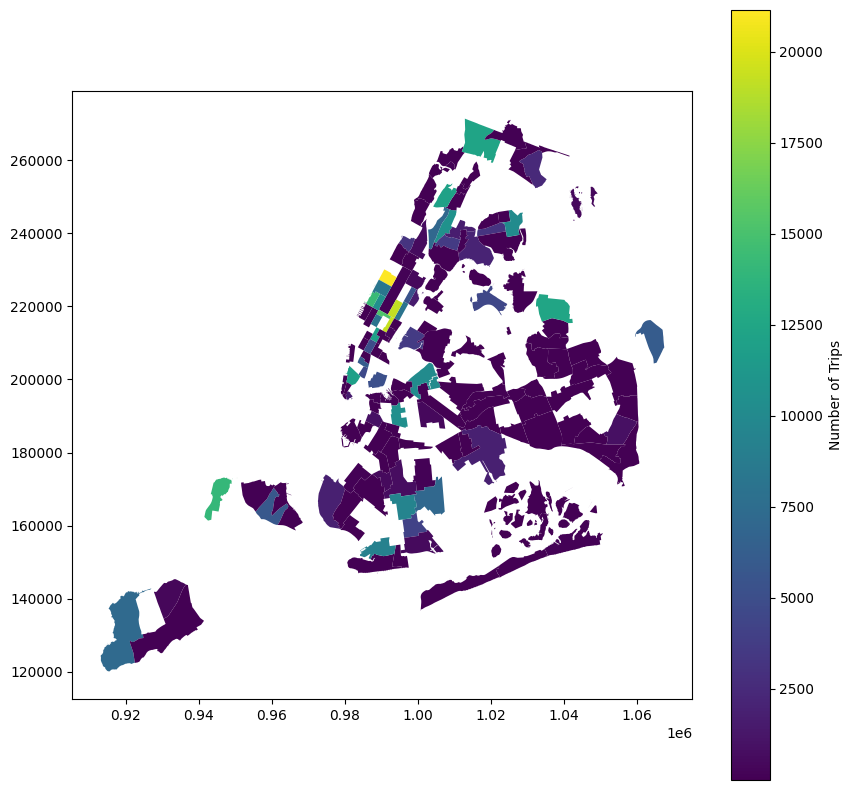

In [255]:
# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Plot the map and display it
zones.plot(column='trip_count', ax=ax, legend=True, legend_kwds={'label': "Number of Trips", 'orientation': "vertical"})
plt.show()


In [256]:
# Displaying the zones DF sorted by the number of trips?
zones.sort_values(by='trip_count', ascending=False)[['zone', 'trip_count']]

,zone,trip_count
237,Upper West Side North,21143.0
161,Midtown East,19267.0
236,Upper East Side South,19219.0
162,Midtown North,15221.0
142,Lincoln Square West,14309.0
...,...,...
252,Willets Point,NaN
253,Williamsbridge/Olinville,NaN
254,Williamsburg (North Side),NaN
257,Woodhaven,NaN


Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**


#### **3.2** Detailed EDA: Insights and Strategies

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1**
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [257]:
# Find routes which have the slowest speeds at different times of the day
# Ensure trip duration is not 0
df_temp = df.copy()
df_temp = df_temp[(df_temp['trip_duration'].dt.total_seconds() > 0) & (df_temp['trip_distance'] > 0)]
df_temp['speed'] = (df_temp['trip_distance'] / df_temp['trip_duration'].dt.total_seconds())*60*60
# df_temp.groupby('pickup_hour')['speed'].max().sort_values(ascending=False)
idx = df_temp.groupby("pickup_hour")["speed"].idxmin()
result = df_temp.loc[idx, ["pickup_hour", "speed", "PULocationID", "DOLocationID"]].reset_index(drop=True)
result

,pickup_hour,speed,PULocationID,DOLocationID
0,0,1.714286,186,186
1,1,0.127919,48,184
2,2,0.141176,255,256
3,3,1.384615,163,163
4,4,1.925134,141,75
5,5,4.142259,43,162
6,6,1.988950,48,48
7,7,1.419355,48,48
8,8,0.867470,233,233
9,9,0.692308,138,138


**3.2.2**
Visualising the number of trips at each hour of the day to find the busiest hour and the number of trips for that hour.

pickup_hour
18    28645
17    26282
19    25114
16    22797
15    22424
21    22141
20    22039
14    21600
13    20235
12    20011
22    19737
11    18526
10    17122
9     16144
23    14726
8     14626
0     10099
7     10067
1      7049
2      4542
6      4184
3      2857
4      1383
5      1207
Name: pickup_hour, dtype: int64


<Axes: xlabel='pickup_hour'>

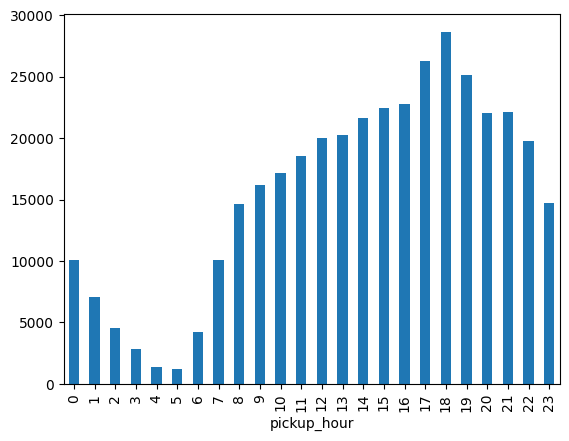

In [258]:
# Visualise the number of trips per hour and find the busiest hour
print(df.groupby('pickup_hour')['pickup_hour'].count().sort_values(ascending=False))
df.groupby('pickup_hour')['pickup_hour'].count().plot(kind="bar")

**3.2.3**
Scaling to find the actual number of trips in the five busiest hours

In [259]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers :
sample_fraction = 1.5/100

df.groupby('pickup_hour')['pickup_hour'].count().sort_values(ascending=False).head()
counts = df.groupby('pickup_hour')['pickup_hour'].count() / sample_fraction
counts_floor = np.floor(counts)
print(counts_floor.apply(lambda x: f"{x:.2f}"))


pickup_hour
0      673266.00
1      469933.00
2      302800.00
3      190466.00
4       92200.00
5       80466.00
6      278933.00
7      671133.00
8      975066.00
9     1076266.00
10    1141466.00
11    1235066.00
12    1334066.00
13    1349000.00
14    1440000.00
15    1494933.00
16    1519800.00
17    1752133.00
18    1909666.00
19    1674266.00
20    1469266.00
21    1476066.00
22    1315800.00
23     981733.00
Name: pickup_hour, dtype: object


**3.2.4**
Comparing hourly traffic pattern on weekdays and weekends.

In [260]:
# Compare traffic trends for the week days and weekends

df_temp['is_weekend'] = df_temp['day'].isin(['Saturday', 'Sunday'])
df_weekend = df_temp.groupby(['pickup_hour', 'is_weekend'])['pickup_hour'].count().unstack()
df_weekend[False] = df_weekend[False]/5
df_weekend[True] = df_weekend[True]/2
df_weekend

is_weekend,False,True
pickup_hour,,
0,916.4,2758.0
1,464.2,2360.0
2,235.8,1681.5
3,133.2,1095.5
4,85.8,477.0
5,193.2,120.5
6,732.8,260.0
7,1820.8,481.0
8,2579.2,865.0


**3.2.5**
Identifying top 10 zones with high hourly pickups and dropoffs to show the existing trends.

In [261]:
# Find top 10 pickup and dropoff zones
df_pickup = df_temp.groupby('PULocationID')['PULocationID'].count().sort_values(ascending=False)
df_drop = df_temp.groupby('DOLocationID')['DOLocationID'].count().sort_values(ascending=False)

df_pickup_hourly = df_temp.groupby(['pickup_hour', 'PULocationID'])['PULocationID'].count().sort_values(ascending=False)
df_drop_hourly = df_temp.groupby(['pickup_hour', 'DOLocationID'])['DOLocationID'].count().sort_values(ascending=False)

print("Top 10 pickup zones: ", df_pickup.head(10))
print("Top 10 dropoff zones: ", df_drop.head(10))

Top 10 pickup zones:  PULocationID
237    21141
161    19267
236    19219
162    15219
142    14309
186    14095
170    12469
239    12335
234    12114
163    12001
Name: PULocationID, dtype: int64
Top 10 dropoff zones:  DOLocationID
236    20106
237    18942
161    15872
170    12497
142    12390
239    12258
141    11772
162    11692
234    10377
68     10348
Name: DOLocationID, dtype: int64


**3.2.6**
Finding the ratio of pickups and dropoffs in each zone to display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [262]:
# Find the top 10 and bottom 10 pickup/dropoff ratios
df_pickup_ratios = df_pickup/df_pickup.sum()
df_drop_ratios = df_drop/df_drop.sum()
print("Ten highest Pickup Ratios", df_pickup_ratios.sort_values(ascending=False).head(10))
print("Ten highest Dropoff Ratios", df_drop_ratios.sort_values(ascending=False).head(10))
print("Ten lowest Pickup Ratios", df_pickup_ratios.sort_values(ascending=True).head(10))
print("Ten lowest Dropoff Ratios", df_drop_ratios.sort_values(ascending=True).head(10))

Ten highest Pickup Ratios PULocationID
237    0.056596
161    0.051579
236    0.051451
162    0.040742
142    0.038306
186    0.037733
170    0.033380
239    0.033022
234    0.032430
163    0.032128
Name: PULocationID, dtype: float64
Ten highest Dropoff Ratios DOLocationID
236    0.053825
237    0.050709
161    0.042491
170    0.033455
142    0.033169
239    0.032816
141    0.031515
162    0.031300
234    0.027780
68     0.027702
Name: DOLocationID, dtype: float64
Ten lowest Pickup Ratios PULocationID
1      0.000003
39     0.000003
47     0.000003
56     0.000003
196    0.000003
29     0.000003
258    0.000003
28     0.000003
11     0.000003
9      0.000003
Name: PULocationID, dtype: float64
Ten lowest Dropoff Ratios DOLocationID
1      0.000003
248    0.000003
38     0.000003
153    0.000003
101    0.000003
64     0.000003
235    0.000003
136    0.000003
167    0.000003
177    0.000003
Name: DOLocationID, dtype: float64


**3.2.7**
Identifying zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [263]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones
df_night = df_temp[(df_temp['pickup_hour'] >= 23) | (df_temp['pickup_hour'] <= 5)]
df_pickup_night = df_night.groupby('PULocationID')['PULocationID'].count().sort_values(ascending=False)
print("Top 10 Pickup Zones: ",df_pickup_night.head(10))

# Dropoff Hour
df_temp['dropoff_hour'] = df_temp['tpep_dropoff_datetime'].dt.hour

df_night = df_temp[(df_temp['dropoff_hour'] >= 23) | (df_temp['dropoff_hour'] <= 5)]
df_dropoff_night = df_night.groupby('DOLocationID')['DOLocationID'].count().sort_values(ascending=False)
print("Top 10 Dropoff Zones: ",df_dropoff_night.head(10))


Top 10 Pickup Zones: 

 PULocationID
79     3628
249    2986
148    2254
48     2128
114    2005
230    1562
186    1420
164    1368
107    1317
234    1264
Name: PULocationID, dtype: int64
Top 10 Dropoff Zones:  DOLocationID
79     2177
48     1659
170    1588
107    1560
141    1409
68     1387
249    1333
263    1243
236    1143
229    1136
Name: DOLocationID, dtype: int64


**3.2.8**
Finding the revenue share for nighttime and daytime hours.

In [264]:
# Filter for night hours (11 PM to 5 AM)
df_pickup_night = df_temp[(df_temp['pickup_hour'] >= 23) | (df_temp['pickup_hour'] <= 5)]
df_pickup_night = df_pickup_night[df_pickup_night['total_amount'] > 0]
total_revenue_night = df_pickup_night['total_amount'].sum()

df_pickup_day = df_temp[(df_temp['pickup_hour'] < 23) | (df_temp['pickup_hour'] > 5)]
df_pickup_day = df_pickup_day[df_pickup_day['total_amount'] > 0]
total_revenue_day = df_pickup_day['total_amount'].sum()

print("Night revenue share: ", total_revenue_night)
print("Daytime revenue share: ", total_revenue_day)

Night revenue share:  885694.9199999999
Daytime revenue share:  7981091.739999999


##### Pricing Strategy

**3.2.9**
For the different passenger counts, we find the average fare per mile per passenger.

In [265]:
# Analyse the fare per mile per passenger for different passenger counts
df_fare_per_mile = df.copy()
df_fare_per_mile = df_fare_per_mile[df_fare_per_mile['trip_distance'] > 0]
df_fare_per_mile = df_fare_per_mile[(df_fare_per_mile['fare_amount'] > 0) & (df_fare_per_mile['trip_distance'] > 0) ]
df_fare_per_mile['fare_per_mile'] = df_fare_per_mile['fare_amount']/df_fare_per_mile['trip_distance']
df_fare_per_mile['per_passenger'] = df_fare_per_mile['fare_per_mile']/df_fare_per_mile['passenger_count']
df_fare_per_mile.groupby('passenger_count')['per_passenger'].mean()

passenger_count
1.0    8.505131
2.0    4.253611
3.0    2.915761
4.0    2.268665
5.0    1.615320
6.0    1.369388
Name: per_passenger, dtype: float64

**3.2.10**
Finding the average fare per mile by hours of the day and by days of the week

In [266]:
# Compare the average fare per mile for different days and for different times of the day
print(df_fare_per_mile.groupby('pickup_hour')['fare_per_mile'].mean().sort_values(ascending=False))
print(df_fare_per_mile.groupby('day')['fare_per_mile'].mean().sort_values(ascending=False))

pickup_hour
14    9.357426
12    9.273978
15    9.269571
11    9.160660
13    9.147435
17    9.090602
10    9.080922
16    9.012908
19    8.930382
9     8.827730
18    8.734189
8     8.276615
2     8.037398
20    7.829105
22    7.558143
21    7.504805
7     7.383306
6     7.274267
23    7.136492
1     7.123208
3     7.049280
0     7.013985
5     6.712204
4     6.553744
Name: fare_per_mile, dtype: float64
day
Thursday     8.909659
Wednesday    8.852795
Tuesday      8.809311
Friday       8.367368
Saturday     8.208880
Monday       8.197912
Sunday       8.045313
Name: fare_per_mile, dtype: float64


**3.2.11**
Analysing the average fare per mile for the different vendors for different hours of the day

In [267]:
# Compare fare per mile for different vendors
df_fare_per_mile.groupby('VendorID')['fare_per_mile'].mean().sort_values(ascending=False)

VendorID
2    8.571576
1    8.354928
Name: fare_per_mile, dtype: float64

**3.2.12**
Comparing the fare rates of the different vendors in a tiered fashion (Average fare per mile for distances upto 2 miles, from 2 to 5 miles and for distances more than 5 miles)


In [268]:
# Defining distance tiers
df_fare_per_mile['distance_tier'] = pd.cut(df_fare_per_mile['trip_distance'], bins=[0, 2, 5, float('inf')], labels=['0-2', '2-5', '5+'])
df_fare_per_mile.groupby(['VendorID','distance_tier'])['fare_per_mile'].mean().unstack()

C:\Users\amdhr\AppData\Local\Temp\ipykernel_18780\3790711515.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_fare_per_mile.groupby(['VendorID','distance_tier'])['fare_per_mile'].mean().unstack()


distance_tier,0-2,2-5,5+
VendorID,,,
1,9.322905,6.344036,5.220549
2,9.695725,6.505858,5.297038


##### Customer Experience and Other Factors

**3.2.13**
Analysing average tip percentages based on trip distances, passenger counts and time of pickup.

-0.06058591043666361
0.0044056712198316285
-0.004091774987658255


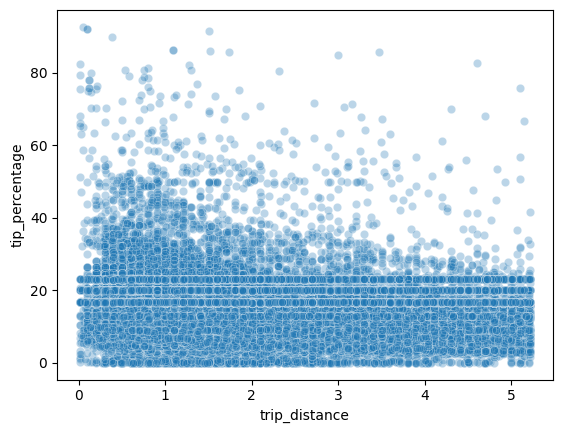

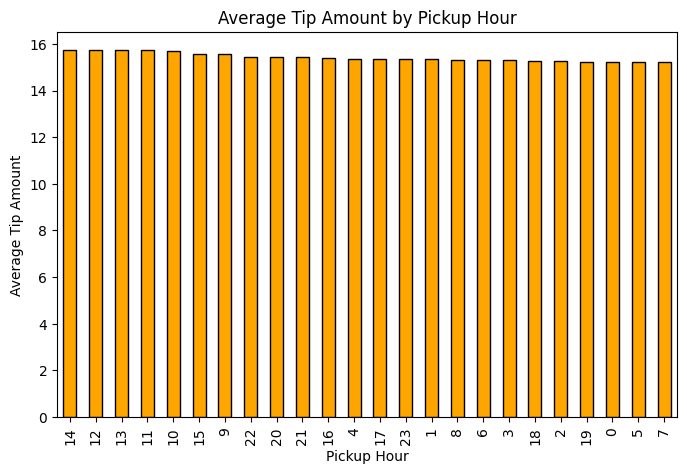

In [269]:
#  Analyze tip percentages based on distances, passenger counts and pickup times
df_tips = df.copy()
df_tips = df_tips[(df_tips['trip_distance'] > 0) & (df_tips['total_amount'] > 0) & (df_tips['tip_amount'] > 0)]
df_tips['tip_percentage'] = (df_tips['tip_amount']*100)/df_tips['total_amount']
print(df_tips['tip_percentage'].corr(df_tips['trip_distance']))
print(df_tips['tip_percentage'].corr(df_tips['passenger_count']))
print(df_tips['tip_percentage'].corr(df_tips['pickup_hour']))

sns.scatterplot(data=df_tips, x="trip_distance", y="tip_percentage", alpha=0.3)

grouped = df_tips.groupby('pickup_hour')['tip_percentage'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
grouped.plot(kind='bar', color='orange', edgecolor='black')
plt.xlabel("Pickup Hour")
plt.ylabel("Average Tip Amount")
plt.title("Average Tip Amount by Pickup Hour")
plt.show()

**3.2.14**
Analyse the variation of passenger count across hours and days of the week.

pickup_hour        0         1         2         3         4         5   \
day                                                                       
Friday       1.412270  1.368771  1.392381  1.462687  1.359712  1.244898   
Monday       1.373308  1.421986  1.427586  1.578431  1.231884  1.128655   
Saturday     1.470588  1.481449  1.510883  1.449515  1.358670  1.228571   
Sunday       1.449664  1.494050  1.436513  1.459087  1.487805  1.397059   
Thursday     1.336986  1.381579  1.384615  1.345324  1.473118  1.140777   
Tuesday      1.371769  1.358407  1.363636  1.350877  1.060000  1.306533   
Wednesday    1.354839  1.365079  1.345455  1.320000  1.435897  1.185567   

pickup_hour        6         7         8         9   ...        14        15  \
day                                                  ...                       
Friday       1.235390  1.261736  1.263305  1.272079  ...  1.354415  1.373225   
Monday       1.196375  1.225909  1.255576  1.262993  ...  1.337658  1.335510   
Satu

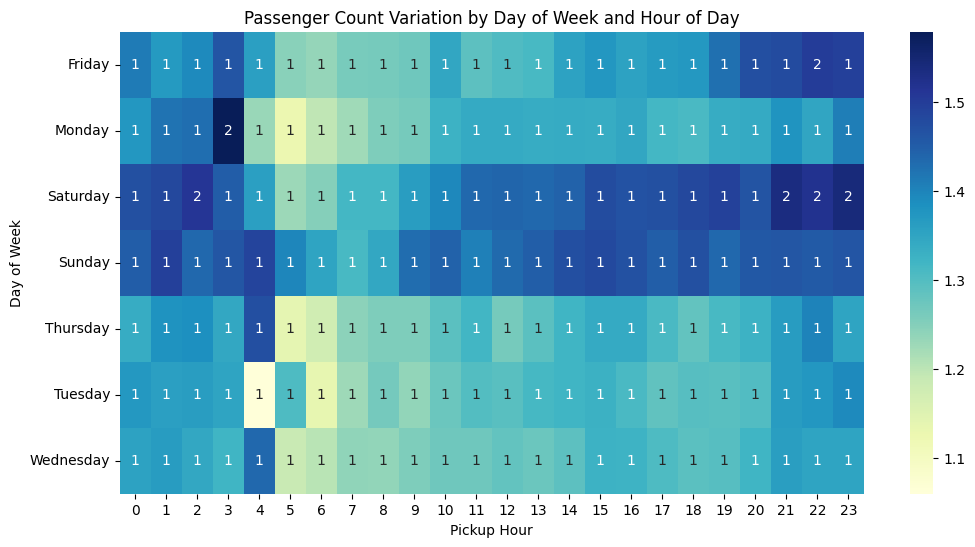

In [270]:
# See how passenger count varies across hours and days
# Group by day_of_week and pickup_hour, summing passenger_count
passenger_variation = df.groupby(['day', 'pickup_hour'])['passenger_count'].mean().unstack()

# Display the grouped data
print(passenger_variation)

plt.figure(figsize=(12,6))
sns.heatmap(passenger_variation, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title("Passenger Count Variation by Day of Week and Hour of Day")
plt.xlabel("Pickup Hour")
plt.ylabel("Day of Week")
plt.show()


**3.2.15**
Analyse the variation of passenger counts across zones

In [271]:
# How does passenger count vary across zones
df.groupby('PULocationID')['passenger_count'].mean().sort_values(ascending=False)

PULocationID
178    6.0
47     5.0
191    3.0
28     3.0
82     2.8
      ... 
212    1.0
215    1.0
216    1.0
217    1.0
1      1.0
Name: passenger_count, Length: 150, dtype: float64

In [272]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.
zones['average_passenger_count'] = merged.groupby('PULocationID')['passenger_count'].mean()
zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,trip_count,average_passenger_count
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",NaN,NaN
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",1.0,1.00000
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2...",NaN,NaN
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",NaN,NaN
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144...",386.0,1.42228


Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16**
Analysing the pickup/dropoff zones or times when extra charges are applied more frequently

In [273]:
# How often is each surcharge applied?
congestion_pickup = df[df["congestion_surcharge"] > 0].groupby('PULocationID')['PULocationID'].count().sort_values(ascending=False)
congestion_dropoff = df[df["congestion_surcharge"] > 0].groupby('DOLocationID')['DOLocationID'].count().sort_values(ascending=False)
congestion_dayhour = df[df["congestion_surcharge"] > 0].groupby(['day', 'pickup_hour'])['pickup_hour'].count().sort_values(ascending=False)

improvement_pickup = df[df["improvement_surcharge"] > 0].groupby('PULocationID')['PULocationID'].count().sort_values(ascending=False)
improvement_dropoff = df[df["improvement_surcharge"] > 0].groupby('DOLocationID')['DOLocationID'].count().sort_values(ascending=False)
improvement_dayhour = df[df["improvement_surcharge"] > 0].groupby(['day', 'pickup_hour'])['pickup_hour'].count().sort_values(ascending=False)

In [274]:
print("Highest congestion surcharge pickup locations: ",congestion_pickup.head())
print("\n\n")
print("Highest congestion surcharge dropoff locations: ",congestion_dropoff.head())
print("\n\n")
print("Highest congestion surcharge day and hour: ",congestion_dayhour.head())
print("\n\n")
print("Highest improvement surcharge pickup locations: ",improvement_pickup.head())
print("\n\n")
print("Highest improvement surcharge dropoff locations: ",improvement_dropoff.head())
print("\n\n")
print("Highest improvement surcharge day and hour: ",improvement_dayhour.head())

Highest congestion surcharge pickup locations:  PULocationID
237    21133
161    19252
236    19175
162    15208
142    14299
Name: PULocationID, dtype: int64



Highest congestion surcharge dropoff locations:  DOLocationID
236    19983
237    18932
161    15855
170    12489
142    12383
Name: DOLocationID, dtype: int64



Highest congestion surcharge day and hour:  day        pickup_hour
Thursday   18             4729
Wednesday  18             4689
Tuesday    18             4527
Friday     18             4241
Thursday   17             4206
Name: pickup_hour, dtype: int64



Highest improvement surcharge pickup locations:  PULocationID
237    21143
161    19267
236    19219
162    15221
142    14309
Name: PULocationID, dtype: int64



Highest improvement surcharge dropoff locations:  DOLocationID
236    20107
237    18944
161    15872
170    12499
142    12391
Name: DOLocationID, dtype: int64



Highest improvement surcharge day and hour:  day        pickup_hour
Thursday   18          

## **4** Conclusion

### **4.1** Final Insights and Recommendations

**4.1.1**
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

**Prioritize Peak Demand Hours (5–7 PM)**

•	Deploy additional cabs during 5–7 PM, when demand reaches its peak.

**Route Optimization for Slow Corridors**

•	Hours and locations with lowest average cab speeds can be routed to faster alternative streets during those periods to reduce trip times and enable more daily trips per vehicle.


**4.1.2**

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

**Reduce Idle Mileage through Predictive Positioning**

•	Assign more drivers to cover both commuter-heavy zones and leisure/nightlife areas during peak hours. Top five areas are: Upper East Side South and North, Midtown Center and East, Lincoln Square East.

**Prioritize High demand zones**

•	Use hourly, weekly pickup–drop-off patterns to position idle cabs closer to anticipated next-trip zones.
Example: Trips ending in high-demand neighbouring zones should be followed by repositioning rather than waiting in low-demand drop-off areas.


**4.1.3**
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

**Peak period premiums**

•	Introduce a fare increase during 5–7 PM weekday peaks and in high-demand zones such as Midtown, airports. These hours show strong willingness to pay due to commuting urgency.

**Off-Peak Discounts to Stimulate Demand**

•	Offer fare reductions during 3–5 AM and low-demand days (Sunday and Monday), especially for airport trips. Small discounts can help improve utilization without undercutting base revenue.

**Cab sharing scheme**

•	Many trips share similar origin-destination pairs (especially airport, nightlife, and business districts). Cab-sharing could reduce per-person fares, making the service more attractive, particularly for cost-sensitive users.
•	Monitor competitive pricing to ensure rates remain attractive against ride-hailing services.
